In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from scipy import linalg as la

# Training
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score

2024-12-11 23:29:39.544762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
Data = pd.read_csv("Life Expectancy Data Cleaned With Insurance.csv")
Data = Data.drop(["Unnamed: 0"], axis=1)
print(Data.columns)
print(np.unique(Data["Country"]))

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
       'Economy_status_Developing', 'Life_expectancy', 'Universal_insurance'],
      dtype='object')
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas, The'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czechi

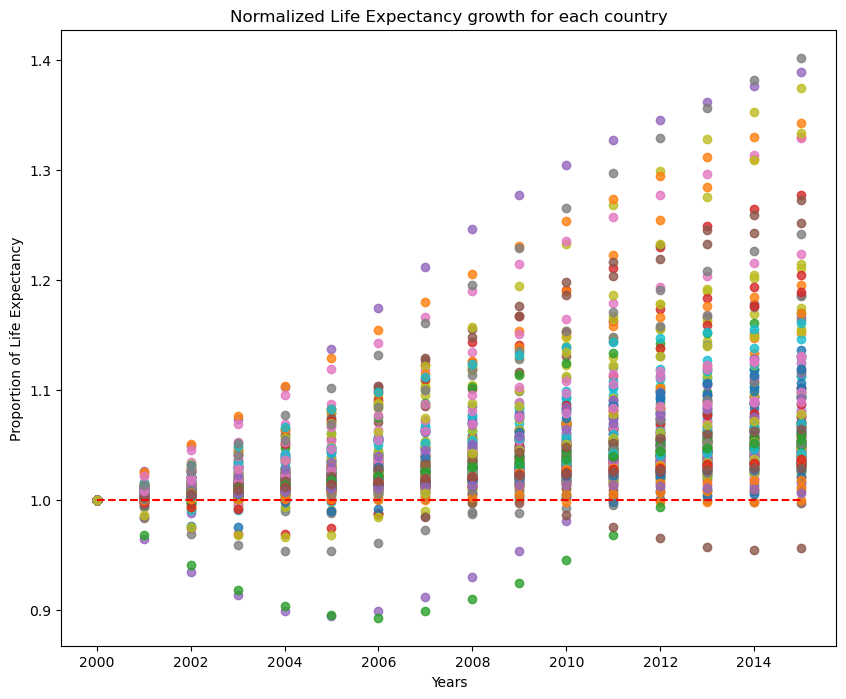

In [3]:
countries = np.unique(Data["Country"])

fig = plt.figure(figsize=(10,8))

for cont in countries:
    life_exp = Data[Data["Country"]==cont]["Life_expectancy"].values
    years = Data[Data["Country"]==cont]["Year"].values
    year2000ind = np.where(years == min(years))  # for the purpose of separate cases where life exp is between 50-60, 60-70, 70-80, and so on.
    life_exp_2000 = life_exp[year2000ind][0]
    plt.scatter(years,life_exp/life_exp_2000, label=cont, alpha=0.8)
plt.plot(np.arange(2000,2016,1),np.ones(16),"--r")
plt.title("Normalized Life Expectancy growth for each country")
plt.ylabel("Proportion of Life Expectancy")
plt.xlabel("Years")
plt.show()

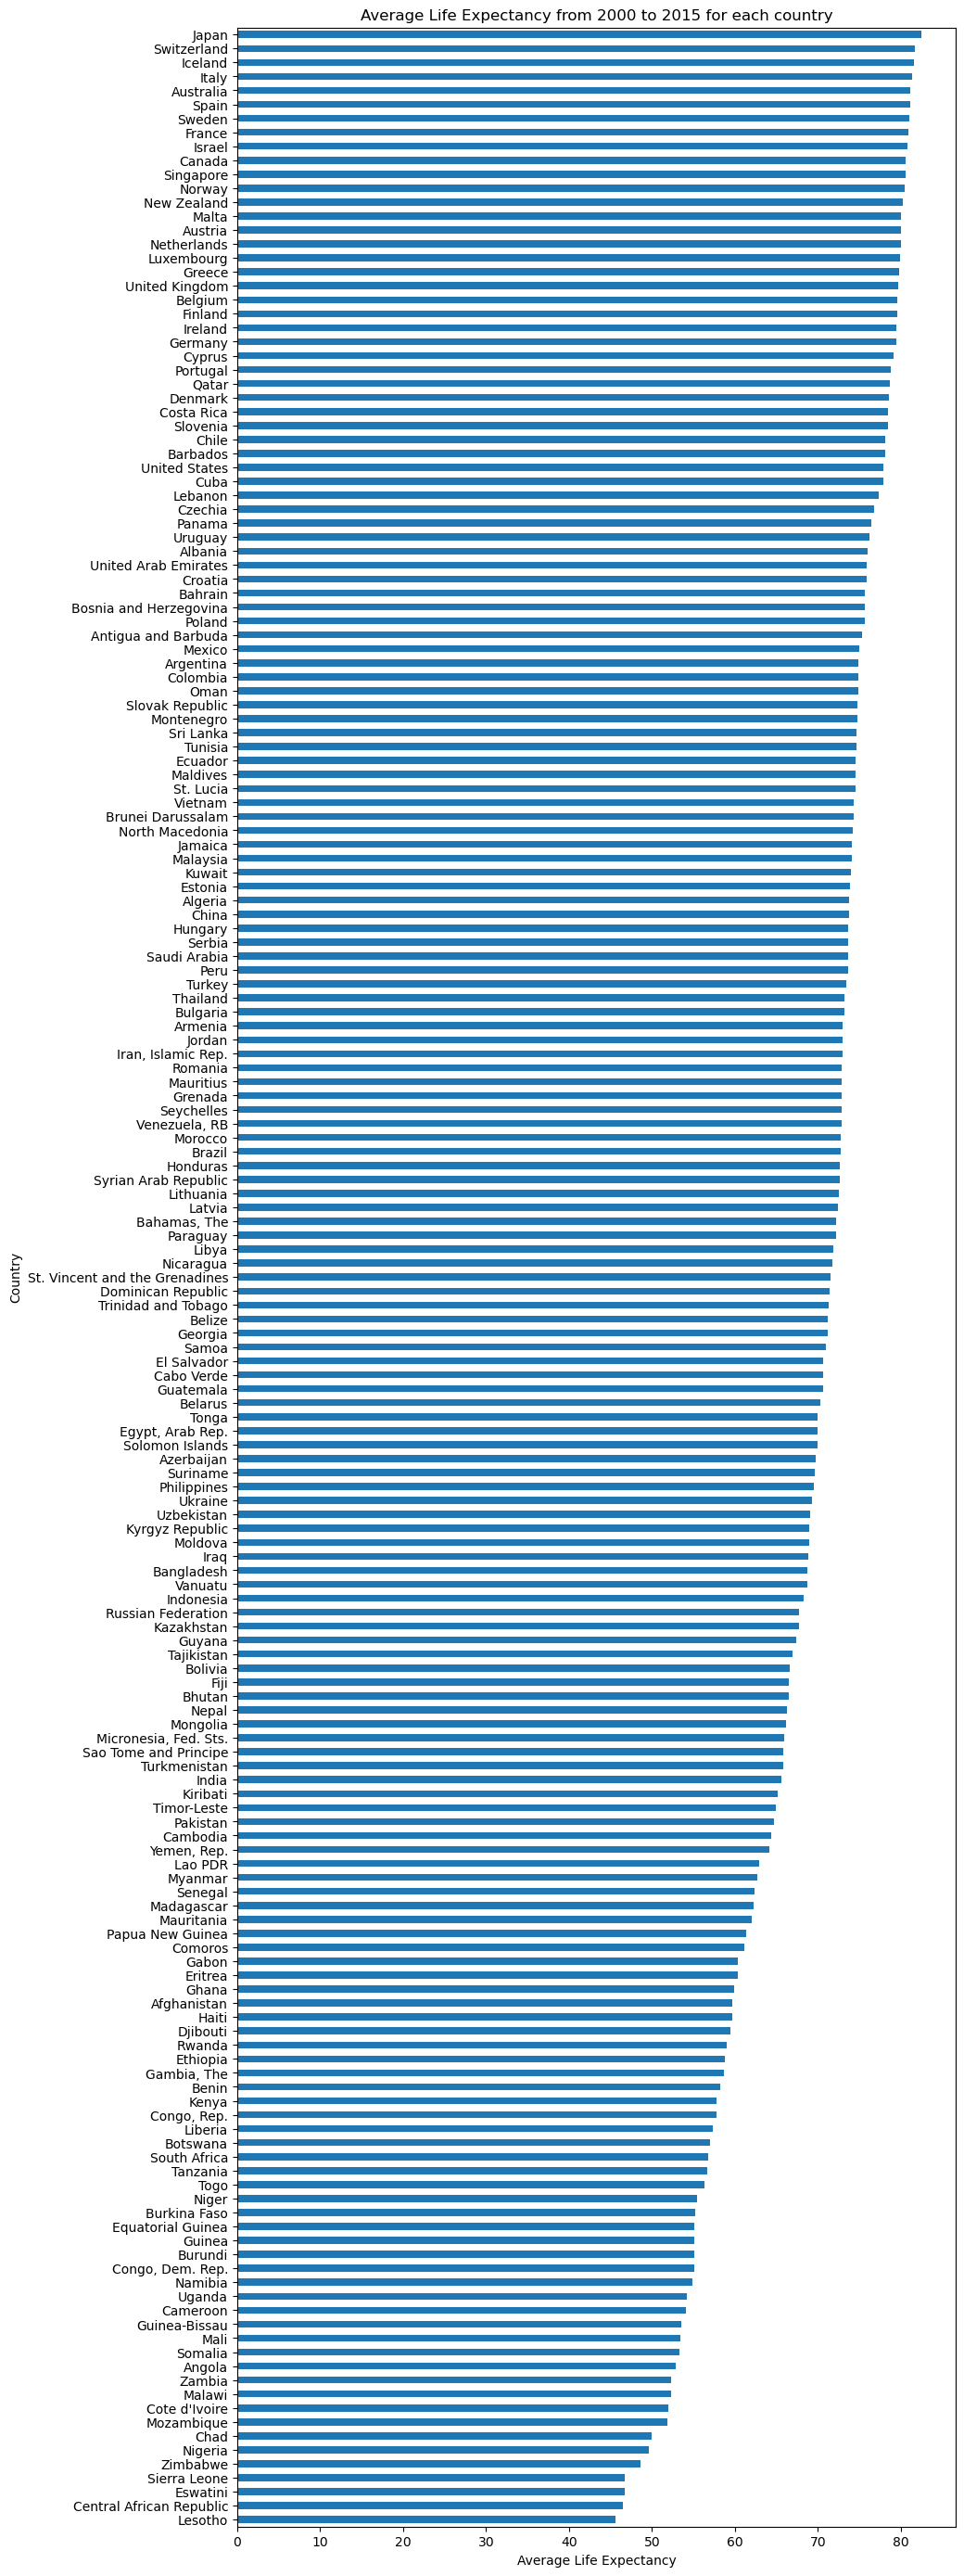

In [4]:
Data.groupby("Country")["Life_expectancy"].mean().sort_values().plot(kind="barh", 
                                                                      title="Average Life Expectancy from 2000 to 2015 for each country", 
                                                                      xlabel="Average Life Expectancy",
                                                                      figsize=(10,35))
plt.show()

# ***Correlation Analysis***

**Title:** *Life Expectancy vs GDP*

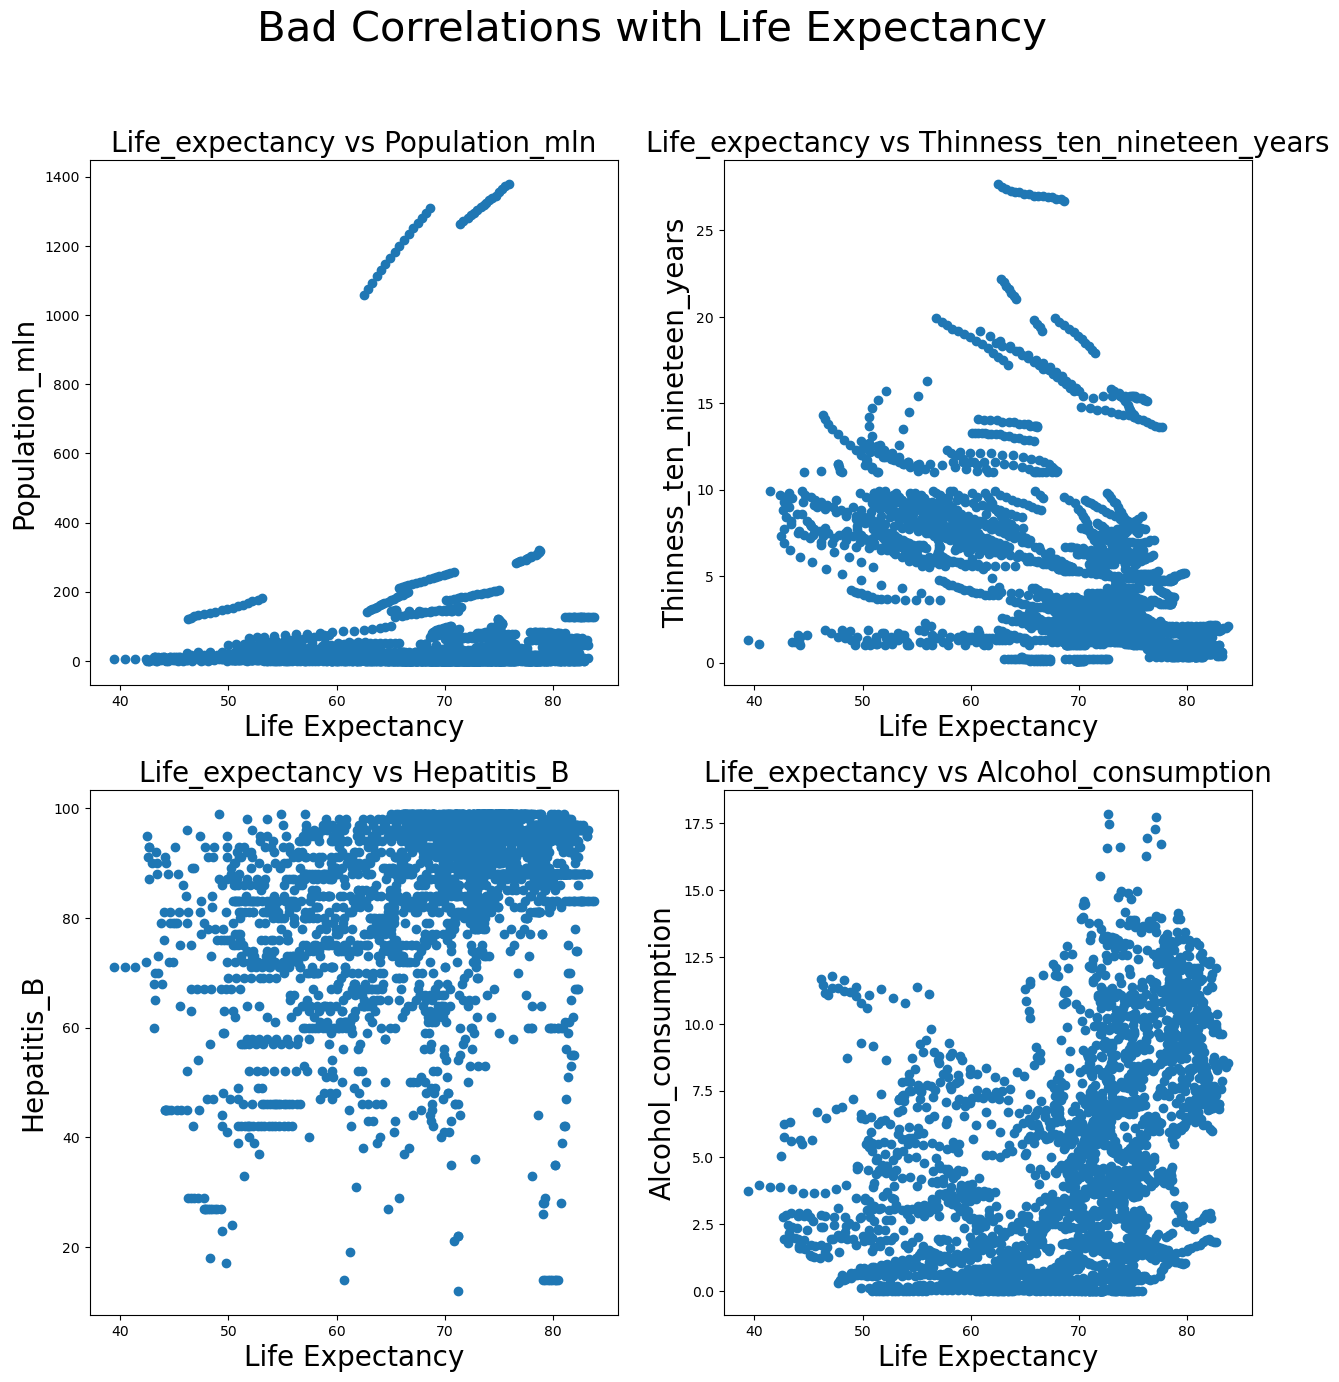

In [5]:
# good = ["Adult_mortality","Under_five_deaths","Infant_deaths","Schooling"]
good = ["Population_mln", "Thinness_ten_nineteen_years", "Hepatitis_B","Alcohol_consumption"]

# for ind, col in enumerate(Data.columns.values[3:]):
#     pd.plotting.scatter_matrix(Data[['Life_expectancy', col]],figsize=(10,8),alpha=0.5,marker="o")
# plt.show()

f, axarr = plt.subplots(2, 2)
f.suptitle("Bad Correlations with Life Expectancy",fontsize=30)
axarr[0, 0].scatter(Data["Life_expectancy"], Data[good[0]])
axarr[0, 0].set_title('Life_expectancy vs '+ good[0], fontsize=20)
axarr[0, 0].set_xlabel("Life Expectancy", fontsize=20)
axarr[0, 0].set_ylabel(good[0], fontsize=20)

axarr[0, 1].scatter(Data["Life_expectancy"], Data[good[1]])
axarr[0, 1].set_title('Life_expectancy vs '+ good[1], fontsize=20)
axarr[0, 1].set_xlabel("Life Expectancy", fontsize=20)
axarr[0, 1].set_ylabel(good[1], fontsize=20)

axarr[1, 0].scatter(Data["Life_expectancy"], Data[good[2]])
axarr[1, 0].set_title('Life_expectancy vs '+ good[2], fontsize=20)
axarr[1, 0].set_xlabel("Life Expectancy", fontsize=20)
axarr[1, 0].set_ylabel(good[2], fontsize=20)

axarr[1, 1].scatter(Data["Life_expectancy"], Data[good[3]])
axarr[1, 1].set_title('Life_expectancy vs '+ good[3], fontsize=20)
axarr[1, 1].set_xlabel("Life Expectancy", fontsize=20)
axarr[1, 1].set_ylabel(good[3], fontsize=20)

f.set_figheight(15)
f.set_figwidth(15)
plt.savefig("sub_Cor_bad.jpg")
plt.show()



# *Overall Correlationship between 'Life Expectancy' and others*

In [6]:
overall = Data.drop(["Country","Region"], axis=1).corr()["Life_expectancy"]
print(overall)
overall_v = np.array(overall.values)
overall_vals = np.array(abs(overall.values))
overall_keys = np.array(overall.keys())
temp_sort = np.sort(overall_vals)

#Training

top_5_keys = [overall_keys[np.where(overall_vals==ind)[0][0]] for ind in temp_sort[-6:-1]]
top_5_vals = overall[top_5_keys]
print("\n", "Top 5 features and scores according to correlation")
# print(top_5_keys[::-1])
print(top_5_vals[::-1])

Year                           0.174359
Infant_deaths                 -0.920032
Under_five_deaths             -0.920419
Adult_mortality               -0.945360
Alcohol_consumption            0.399159
Hepatitis_B                    0.417804
Measles                        0.490019
BMI                            0.598423
Polio                          0.641217
Diphtheria                     0.627541
Incidents_HIV                 -0.553027
GDP_per_capita                 0.583090
Population_mln                 0.026298
Thinness_ten_nineteen_years   -0.467824
Thinness_five_nine_years      -0.458166
Schooling                      0.732484
Economy_status_Developed       0.523791
Economy_status_Developing     -0.523791
Life_expectancy                1.000000
Universal_insurance            0.479867
Name: Life_expectancy, dtype: float64

 Top 5 features and scores according to correlation
Adult_mortality     -0.945360
Under_five_deaths   -0.920419
Infant_deaths       -0.920032
Schooling          

In [7]:
overall = Data.drop(["Country","Region", "Infant_deaths","Under_five_deaths", "Adult_mortality"], axis=1).corr()["Life_expectancy"]
print(overall)
overall_v = np.array(overall.values)
overall_vals = np.array(abs(overall.values))
overall_keys = np.array(overall.keys())
temp_sort = np.sort(overall_vals)

top_5_keys = [overall_keys[np.where(overall_vals==ind)[0][0]] for ind in temp_sort[-6:-1]]
top_5_vals = overall[top_5_keys]
print("\n", "Top 5 features and scores according to correlation")
# print(top_5_keys[::-1])
print(top_5_vals[::-1])

Year                           0.174359
Alcohol_consumption            0.399159
Hepatitis_B                    0.417804
Measles                        0.490019
BMI                            0.598423
Polio                          0.641217
Diphtheria                     0.627541
Incidents_HIV                 -0.553027
GDP_per_capita                 0.583090
Population_mln                 0.026298
Thinness_ten_nineteen_years   -0.467824
Thinness_five_nine_years      -0.458166
Schooling                      0.732484
Economy_status_Developed       0.523791
Economy_status_Developing     -0.523791
Life_expectancy                1.000000
Universal_insurance            0.479867
Name: Life_expectancy, dtype: float64

 Top 5 features and scores according to correlation
Schooling         0.732484
Polio             0.641217
Diphtheria        0.627541
BMI               0.598423
GDP_per_capita    0.583090
Name: Life_expectancy, dtype: float64


# ***Training***

In [8]:
# # Add colume "LiveLong" as an indication showing the data has higher life expectancy than 
# # the global average of life expectancy.
# mean_ = Data["Life_expectancy"].mean()
# Data["LiveLong"] = Data["Life_expectancy"].values > mean_

# y = Data["LiveLong"]
# X = Data.drop(["LiveLong","Life_expectancy"], axis=1)

# # separate the train and the test datasets
# X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.1, random_state=42)



In [9]:
# Betas = []

# for cont in countries:
#     life_exp = Data[Data["Country"]==cont]["Life_expectancy"].values
#     years = Data[Data["Country"]==cont]["Year"].values
#     # for each country
#     X = Data[Data["Country"]==cont].drop(["Life_expectancy","Year","Country","Region"], axis=1).values
#     X = sm.add_constant(X)
#     results = sm.OLS(life_exp, X).fit()
#     Beta_est = results.params
#     Betas.append(Beta_est)

In [10]:
Data = Data.replace(True,1)
Data = Data.replace(False,0)

/tmp/ipykernel_12042/1713643295.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data = Data.replace(False,0)


In [11]:
# setting
max_comb = []
max_Rsqured = 0
independent_vars = Data.drop(["Life_expectancy","Year","Country","Region", "Infant_deaths","Under_five_deaths", "Adult_mortality", "GDP_per_capita", "Economy_status_Developed", "Economy_status_Developing"], axis=1).columns.values

# get the all combinations of independent variables
combs = []
for i in range(1,len(independent_vars)):
    for el in combinations(independent_vars,i):
        combs.append(list(el))
y = Data["Life_expectancy"].values

# find the max R squared
for combination in combs:
    X_temp = Data[combination]
    X = sm.add_constant(X_temp).values
    
    model = sm.OLS(y,X).fit()
    Rsquared = model.rsquared
    if max_Rsqured < Rsquared:
        max_Rsqured = Rsquared
        max_comb = combination
        print(max_Rsqured)
        print(max_comb)
        print(len(max_comb))

0.15932799316340152
['Alcohol_consumption']
1
0.174560543411442
['Hepatitis_B']
1
0.24011821796681976
['Measles']
1
0.3581104755418737
['BMI']
1
0.411159825039665
['Polio']
1
0.5365334971672637
['Schooling']
1
0.5408638776904167
['Alcohol_consumption', 'Schooling']
2
0.5668146720268934
['Hepatitis_B', 'Schooling']
2
0.5721485184642381
['BMI', 'Incidents_HIV']
2
0.6257662161929398
['Polio', 'Incidents_HIV']
2
0.7080038063945133
['Incidents_HIV', 'Schooling']
2
0.7083189160926904
['Alcohol_consumption', 'Incidents_HIV', 'Schooling']
3
0.7373798092847537
['Hepatitis_B', 'Incidents_HIV', 'Schooling']
3
0.7783535296707429
['Polio', 'Incidents_HIV', 'Schooling']
3
0.7783658590687946
['Alcohol_consumption', 'Polio', 'Incidents_HIV', 'Schooling']
4
0.778517369367292
['Hepatitis_B', 'Polio', 'Incidents_HIV', 'Schooling']
4
0.779551563227155
['Measles', 'Polio', 'Incidents_HIV', 'Schooling']
4
0.7909871791311212
['BMI', 'Polio', 'Incidents_HIV', 'Schooling']
4
0.8022054162928293
['Polio', 'Incid

In [51]:
# Note that there isn't much change after combination of 5 so we will Stick with 
# ['BMI', 'Polio', 'Incidents_HIV', 'Schooling', 'Universal_insurance']
X_temp = Data[['BMI', 'Polio', 'Incidents_HIV', 'Schooling', 'Universal_insurance']]
X = sm.add_constant(X_temp).values
y = Data["Life_expectancy"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = sm.OLS(y_train,X_train).fit()
y_hat = model.predict(X_test)
print(1 - (la.norm(y_test - y_hat)**2)/(la.norm(y_test - np.mean(y_test))**2))

0.8360334621375052


In [52]:
# Great what now? Now we analyze when we flip the role
mask = Data["Year"] == 2015
newestData = Data[mask]
X_temp2 = newestData[['BMI', 'Polio', 'Incidents_HIV', 'Schooling', 'Universal_insurance']]
X_temp2['Universal_insurance'] = 1
X2 = sm.add_constant(X_temp2).values
X2 = np.hstack([np.ones((len(X2), 1)), X2])
predictions_of_universalhealth = model.predict(X2)

/tmp/ipykernel_12042/3173595116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_temp2['Universal_insurance'] = 1


In [53]:
countries = newestData['Country'].values
ui = newestData['Universal_insurance'].values
act_expectancy = newestData['Life_expectancy'].values
better_ui_countries = []
worse_ui_countries = []
for i in range(len(newestData)):
    if ui[i] == 0:
        if act_expectancy[i] < predictions_of_universalhealth[i]:
            better_ui_countries.append(countries[i])
        else:
            worse_ui_countries.append(countries[i])

In [54]:
print(len(better_ui_countries))
print(len(worse_ui_countries))

82
28
